In [5]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.backend import function
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input, Multiply
from tensorflow.keras.applications import InceptionV3,MobileNet

In [6]:
# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Global Attention Module Declaration

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Multiply, Add, Conv2D, BatchNormalization, ReLU, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
def channel_attention(input, ratio=16):
    avg_pool = GlobalAveragePooling2D()(input)
    max_pool = GlobalMaxPooling2D()(input)

    channel_avg = Dense(units=input.shape[-1] // ratio, activation='relu',kernel_initializer='he_normal',use_bias=True,bias_initializer='zeros')(avg_pool)
    channel_max = Dense(units=input.shape[-1] // ratio, activation='relu',kernel_initializer='he_normal',use_bias=True,bias_initializer='zeros')(max_pool)

    channel_avg = Dense(units=input.shape[-1], activation='sigmoid',kernel_initializer='he_normal',use_bias=True)(channel_avg)
    channel_max = Dense(units=input.shape[-1], activation='sigmoid',kernel_initializer='he_normal',use_bias=True)(channel_max)

    channel_attention = Add()([channel_avg, channel_max])
    channel_attention = Multiply()([input, Reshape((1, 1, input.shape[-1]))(channel_attention)])

    return channel_attention

In [8]:
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid

def attach_attention_module(net, attention_module):
  if attention_module == 'se_block': # SE_block
    net = se_block(net)
  elif attention_module == 'cbam_block': # CBAM_block
    net = cbam_block(net)
  else:
    raise Exception("'{}' is not supported attention module!".format(attention_module))

  return net

def se_block(input_feature, ratio=8):
	"""Contains the implementation of Squeeze-and-Excitation(SE) block.
	As described in https://arxiv.org/abs/1709.01507.
	"""
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]

	se_feature = GlobalAveragePooling2D()(input_feature)
	se_feature = Reshape((1, 1, channel))(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	se_feature = Dense(channel // ratio,
					   activation='relu',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel//ratio)
	se_feature = Dense(channel,
					   activation='sigmoid',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	if K.image_data_format() == 'channels_first':
		se_feature = Permute((3, 1, 2))(se_feature)

	se_feature = multiply([input_feature, se_feature])
	return se_feature

def cbam_block(cbam_feature, ratio=8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])
		

# Global Mobile Net Model Fine Tuning

In [10]:
def create_Global_attention_augmented_mobilenet(input_shape, num_classes,attention=True):
    # Load MobileNet base model without top layer
    base_model = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    # Attention augmented MobileNet architecture
    
    input_tensor = Input(shape=input_shape)
    x = base_model(input_tensor)
    # Apply attention module
    if(attention):
        x = Add()([attach_attention_module(x, attention_module='se_block'),x])
        x = BatchNormalization()(x)
        x = Activation('relu')(x)  # Applying ReLU activation after batch normalization

    # Add classification layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output_tensor = Dense(num_classes, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

# Global InceptionV3 Model Fine Tuning

In [11]:
def create_Global_InceptionV3_model(input_shape, num_classes,attention=True):
    
    # Load Inception-v3 base model without top layer
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    # Attention augmented Inception-v3 architecture
    input_tensor = Input(shape=input_shape)
    x = base_model(input_tensor)

    # Apply attention module
    if(attention):
        x = Add()([attach_attention_module(x, attention_module='se_block'),x])
        x = BatchNormalization()(x)
        x = Activation('relu')(x)  # Applying ReLU activation after batch normalization


    # Add classification layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output_tensor = Dense(num_classes, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model


In [12]:
import numpy as np
from sklearn.metrics import classification_report, balanced_accuracy_score, average_precision_score, confusion_matrix

def evaluate_classification(y_true, y_pred, average='macro'):
    """
    Evaluate the classification performance and calculate micro-average, balanced accuracy, and average precision.

    Parameters:
        y_true (numpy array or list): True labels.
        y_pred (numpy array or list): Predicted labels.
        average (str, optional): The averaging strategy to use for average precision.
                                 Possible values are 'macro', 'micro', 'weighted', and None.
                                 Default is 'macro'.

    Returns:
        report (str): The classification report as a string.
        balanced_acc (float): The balanced accuracy.
        avg_precision (float): The average precision.
        micro_avg_precision (float): The micro-average precision.
        micro_avg_recall (float): The micro-average recall.
        micro_avg_f1_score (float): The micro-average F1-score.
    """
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=1)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    avg_precision = average_precision_score(y_true, y_pred, average=average)

    # Calculate micro-average precision and recall using confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tp_sum = np.sum(np.diag(cm))
    pred_sum = np.sum(cm, axis=0)
    true_sum = np.sum(cm, axis=1)
    micro_avg_precision = tp_sum / pred_sum.sum()
    micro_avg_recall = tp_sum / true_sum.sum()
    micro_avg_f1_score = 2 * (micro_avg_precision * micro_avg_recall) / (micro_avg_precision + micro_avg_recall)

    return report, balanced_acc, avg_precision, micro_avg_precision, micro_avg_recall, micro_avg_f1_score


# constant Declaration

In [13]:
# 1. Load and split the dataset
train_data_dir = '/kaggle/input/cataract-image-dataset/processed_images/train'
#validation_data_dir = 'd:/chaman/cataract/test'
input_shape = (224, 224)
batch_size = 32
num_classes=2


# Traing and Validation + Data Augmentation Module

In [14]:
# 2. Preprocess the images
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% validation split
)

#validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',  # Updated to 'categorical'
    subset="training"
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Subset for validation data
)

Found 393 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation loss
    patience=40,          # Number of epochs with no improvement to wait
    restore_best_weights=True,  # Restore the best model weights when stopping

)
cp_callback1 = tf.keras.callbacks.ModelCheckpoint('./fpseweights.h5', save_weights_only=True, verbose=1, save_best_only=True)

In [16]:
cp_callback2 = tf.keras.callbacks.ModelCheckpoint('./fpseweights1.h5', save_weights_only=True, verbose=1, save_best_only=True)

In [17]:
cp_callback3 = tf.keras.callbacks.ModelCheckpoint('./fpseweights2.h5', save_weights_only=True, verbose=1, save_best_only=True)

# Local MobileNet Model Compilation

In [18]:

MobileNetModel = create_Global_attention_augmented_mobilenet(input_shape + (3,), num_classes,attention=True)

# 4. Compile the model
MobileNetModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


17225924/17225924 [==============================] - 1s 0us/step


# Local  InceptionV3 Model Compilation

In [19]:
InceptionV3Model = create_Global_InceptionV3_model(input_shape + (3,), num_classes)

InceptionV3Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


87910968/87910968 [==============================] - 3s 0us/step


# Global Attention Augmented MobileNet Model Training

In [20]:
# 5. Train the model
epochs = 100

# Create a directory to save the best model weights during training
os.makedirs('models', exist_ok=True)
model_checkpoint = ModelCheckpoint('models/best_GlobalmobilnetmodelD1.h5', save_best_only=True, save_weights_only=True)

history = MobileNetModel.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=[model_checkpoint,cp_callback1]
)


Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.7292
Epoch 1: val_loss improved from inf to 0.29813, saving model to ./fpseweights.h5
12/12 [==============================] - 31s 2s/step - loss: 0.6785 - accuracy: 0.7292 - val_loss: 0.2981 - val_accuracy: 0.9271
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.9224
Epoch 2: val_loss did not improve from 0.29813
12/12 [==============================] - 20s 2s/step - loss: 0.2215 - accuracy: 0.9224 - val_loss: 0.3336 - val_accuracy: 0.8958
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.9529
Epoch 3: val_loss improved from 0.29813 to 0.13783, saving model to ./fpseweights.h5
12/12 [==============================] - 18s 2s/step - loss: 0.1410 - accuracy: 0.9529 - val_loss: 0.1378 - val_accuracy: 0.9688
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 0.1329 - accuracy: 0.9501
Epoch 4: val_loss im

# Global InceptionV3 Model Training

In [21]:
# Create a directory to save the best model weights during training
os.makedirs('models', exist_ok=True)
model_checkpoint = ModelCheckpoint('models/best_GlobalInceptionModelD1.h5', save_best_only=True, save_weights_only=True)

InceptionV3history = InceptionV3Model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=[model_checkpoint,cp_callback2]
)


Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 1.5632 - accuracy: 0.6399
Epoch 1: val_loss improved from inf to 0.71424, saving model to ./fpseweights1.h5
12/12 [==============================] - 29s 2s/step - loss: 1.5632 - accuracy: 0.6399 - val_loss: 0.7142 - val_accuracy: 0.8854
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.5816 - accuracy: 0.8310
Epoch 2: val_loss improved from 0.71424 to 0.48194, saving model to ./fpseweights1.h5
12/12 [==============================] - 19s 2s/step - loss: 0.5816 - accuracy: 0.8310 - val_loss: 0.4819 - val_accuracy: 0.8646
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.3713 - accuracy: 0.8333
Epoch 3: val_loss improved from 0.48194 to 0.31987, saving model to ./fpseweights1.h5
12/12 [==============================] - 19s 2s/step - loss: 0.3713 - accuracy: 0.8333 - val_loss: 0.3199 - val_accuracy: 0.8646
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 0.215

In [22]:
MobileNetModel.save('GAAMD1.h5')
InceptionV3Model.save('GAAIV3D1.h5')

In [23]:
import time
import numpy as np
from keras.models import Model
from keras.layers import Input
#from keras.utils.generic_utils import get_custom_objects
from keras.optimizers import Adam

def compute_gflops_and_model_size(model, input_shape=(1, 224, 224, 3)):
    input_data = np.random.rand(*input_shape).astype(np.float32)
    input_tensor = Input(shape=input_data.shape[1:])
    model = Model(inputs=input_tensor, outputs=model(input_tensor))

    macs = model.count_params()
    params = np.sum([np.prod(w.shape) for w in model.get_weights()])

    GFlops = macs * 2.0 / 10**9
    model_size = params * 4.0 / 1024 / 1024  # Convert to MB
    return GFlops, model_size

def compute_params(model):
    return model.count_params()

def compute_fps(model, input_shape=(1, 224, 224, 3), epoch=100, device=None):
    """
    Frames per second
    :param input_shape: Input data shape
    """
    if device:
        model.compile(optimizer=Adam(), loss='mean_squared_error')  # Compile the model to initialize the weights
        model.set_weights(model.get_weights())
    
    total_time = 0.0
    data = np.random.rand(*input_shape).astype(np.float32)
    
    for i in range(epoch):
        start = time.time()
        predictions = model.predict(data, batch_size=input_shape[0])
        end = time.time()
        total_time += (end - start)

    return total_time / epoch

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
#from tensorflow.keras.applications import AlexNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def compute_accuracy(y_true, y_pred, top_k=1):
    top_k_categorical_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=top_k)
    top_k_categorical_accuracy.update_state(y_true, y_pred)
    return top_k_categorical_accuracy.result().numpy() * 100.0

def compute_error(accuracy):
    return 100.0 - accuracy

if __name__ == '__main__':
    # Load the CIFAR-10 dataset
    #(x_test, y_test), _ = cifar10.load_data()
    #x_test = x_test.astype(np.float32) / 255.0
    #y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

    #model = AlexNet(weights='imagenet', input_shape=(224, 224, 3), include_top=True)

    # Resize the images to (224, 224) and normalize
    #datagen = ImageDataGenerator(
    #    preprocessing_function=lambda x: (x - 0.5) / 0.5,
    #    width_shift_range=0.1,
    #    height_shift_range=0.1,
    #    fill_mode='reflect'
    #)

    #data_generator = datagen.flow(x_test, y_test, batch_size=128)

    # Calculate top-1 and top-5 accuracy
    top1_accuracy = compute_accuracy(y_test, model.predict(x_test), top_k=1)
    #top5_accuracy = compute_accuracy(y_test, model.predict(x_test), top_k=5)

    # Calculate top-1 and top-5 error
    top1_error = compute_error(top1_accuracy)
    #top5_error = compute_error(top5_accuracy)

    print(f'Top 1 Accuracy: {top1_accuracy:.3f}%')
    print(f'Top 5 Accuracy: {top5_accuracy:.3f}%')
    print(f'Top 1 Error: {top1_error:.3f}%')
    print(f'Top 5 Error: {top5_error:.3f}%')

NameError: name 'y_test' is not defined

In [25]:
print(f'InceptionV3: GFlops and Model Size: {compute_gflops_and_model_size(InceptionV3Model)}')
print(f'InceptionV3:Parameter Counting: {compute_params(InceptionV3Model)}')



InceptionV3: GFlops and Model Size: (0.049924164, 95.22278594970703)
InceptionV3:Parameter Counting: 24962082


In [26]:
print(f'MobileNet: GFlops and Model Size: {compute_gflops_and_model_size(MobileNetModel)}')
print(f'MobileNet:Parameter Counting: {compute_params(MobileNetModel)}')



MobileNet: GFlops and Model Size: (0.009095812, 17.34888458251953)
MobileNet:Parameter Counting: 4547906


In [27]:
print(f'MobileNet FPS: {compute_fps(MobileNetModel)}')

1/1 [==============================] - 0s 18ms/step
MobileNet FPS: 0.05252772092819214


# Global MobileNet Model Validation Evaluation

In [28]:
print(f'InceptionV3 FPS: {compute_fps(InceptionV3Model)}')

1/1 [==============================] - 0s 25ms/step
InceptionV3 FPS: 0.08442496061325074


In [29]:
# 6. Evaluate the model
MobileNetEvaluation = MobileNetModel.evaluate(validation_generator)
print("Validation Accuracy: {:.2f}%".format(MobileNetEvaluation[1] * 100))

4/4 [==============================] - 2s 507ms/step - loss: 0.1711 - accuracy: 0.9592
Validation Accuracy: 95.92%


# Global InceptionV3 Model Validation Evaluation

In [30]:
# 6. Evaluate the model
InceptionV3Evaluation = InceptionV3Model.evaluate(validation_generator)
print("Validation Accuracy: {:.2f}%".format(InceptionV3Evaluation[1] * 100))

4/4 [==============================] - 3s 722ms/step - loss: 0.1131 - accuracy: 0.9592
Validation Accuracy: 95.92%


# Common TestGenerator Declaration Module

In [31]:
# Test data directory
test_data_dir = '/kaggle/input/cataract-image-dataset/processed_images/test'
input_shape = (224, 224)
batch_size = 32

# Preprocess the test images
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',  # Set to 'categorical' if you used the updated code
    shuffle=False
)

# Load the saved model



Found 121 images belonging to 2 classes.


# Global MobileNet Model Test Evaluation

In [32]:
# Evaluate the model on the test set
MobileNetTestEvaluation = MobileNetModel.evaluate_generator(test_generator)
print("Test Accuracy: {:.2f}%".format(MobileNetTestEvaluation[1] * 100))

/tmp/ipykernel_29/4230226302.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  MobileNetTestEvaluation = MobileNetModel.evaluate_generator(test_generator)


Test Accuracy: 96.69%


# Global InceptionV3 Model Test Evaluation

In [33]:
# Evaluate the model on the test set
InceptionV3TestEvaluation = InceptionV3Model.evaluate_generator(test_generator)
print("Test Accuracy: {:.2f}%".format(InceptionV3TestEvaluation[1] * 100))

/tmp/ipykernel_29/1916027015.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  InceptionV3TestEvaluation = InceptionV3Model.evaluate_generator(test_generator)


Test Accuracy: 93.39%


# Common Classification Report Module

In [34]:
from sklearn.metrics import classification_report

# Load the saved model
#model = tf.keras.models.load_model('models/final_model.h5')  # Update with the correct path

# Get the true labels for the test set
true_labels = test_generator.classes

# Compute and print the classification report
class_names = list(test_generator.class_indices.keys())


# Global MobileNet Model Classification Report

In [35]:
# Generate predictions for the test set
MobileNetPredictions = MobileNetModel.predict_generator(test_generator)
MobileNetPredicted_labels = np.argmax(MobileNetPredictions, axis=1)
MobileNetReport = classification_report(true_labels, MobileNetPredicted_labels, target_names=class_names)
print(MobileNetReport)


/tmp/ipykernel_29/2479908967.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  MobileNetPredictions = MobileNetModel.predict_generator(test_generator)


              precision    recall  f1-score   support

    cataract       0.98      0.95      0.97        61
      normal       0.95      0.98      0.97        60

    accuracy                           0.97       121
   macro avg       0.97      0.97      0.97       121
weighted avg       0.97      0.97      0.97       121



In [36]:
report, balanced_acc, avg_precision, micro_avg_precision, micro_avg_recall, micro_avg_f1_score = evaluate_classification(true_labels,  MobileNetPredicted_labels)

# Print the classification report and additional metrics
#print("Classification Report:\n", report)
print("Micro-average F1-score:", micro_avg_f1_score)
print("Balanced Accuracy:", balanced_acc)
print("Average Precision:", avg_precision)
print("Micro-average Precision:", micro_avg_precision)
print("Micro-average Recall:", micro_avg_recall)

Micro-average F1-score: 0.9669421487603306
Balanced Accuracy: 0.9670765027322403
Average Precision: 0.9440171509819604
Micro-average Precision: 0.9669421487603306
Micro-average Recall: 0.9669421487603306


# Global InceptionV3 Model Classification Report

In [37]:
# Generate predictions for the test set
InceptionV3Predictions = InceptionV3Model.predict_generator(test_generator)
InceptionV3Predicted_labels = np.argmax(InceptionV3Predictions, axis=1)
InceptionV3Report = classification_report(true_labels, InceptionV3Predicted_labels, target_names=class_names)
print(InceptionV3Report)


/tmp/ipykernel_29/1935537709.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  InceptionV3Predictions = InceptionV3Model.predict_generator(test_generator)


              precision    recall  f1-score   support

    cataract       0.93      0.93      0.93        61
      normal       0.93      0.93      0.93        60

    accuracy                           0.93       121
   macro avg       0.93      0.93      0.93       121
weighted avg       0.93      0.93      0.93       121



In [38]:
report, balanced_acc, avg_precision, micro_avg_precision, micro_avg_recall, micro_avg_f1_score = evaluate_classification(true_labels,  InceptionV3Predicted_labels)

# Print the classification report and additional metrics
#print("Classification Report:\n", report)
print("Micro-average F1-score:", micro_avg_f1_score)
print("Balanced Accuracy:", balanced_acc)
print("Average Precision:", avg_precision)
print("Micro-average Precision:", micro_avg_precision)
print("Micro-average Recall:", micro_avg_recall)

Micro-average F1-score: 0.9338842975206612
Balanced Accuracy: 0.9338797814207651
Average Precision: 0.9041689623507806
Micro-average Precision: 0.9338842975206612
Micro-average Recall: 0.9338842975206612


# Global MobileNet Model Confusion Matrix

<Figure size 500x300 with 0 Axes>

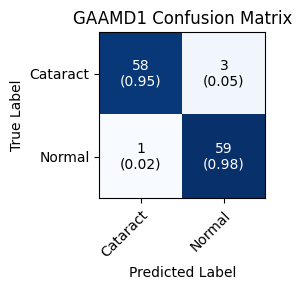

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix


# Load the saved model
#model = tf.keras.models.load_model('models/final_model.h5')  # Update with the correct path

# Generate predictions for the test data


# Generate the confusion matrix
MobileNetCM = confusion_matrix(true_labels, MobileNetPredicted_labels)

# Plot confusion matrix
plt.figure(figsize=(5, 3))
class_names = list(test_generator.class_indices.keys())
#sns.heatmap(MobileNetCM, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plot_confusion_matrix(conf_mat=MobileNetCM, figsize=(5, 3), class_names=['Cataract', 'Normal'], show_normed=True)
plt.title('GAAMD1 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
#plt.savefig('GAAMD1.eps',dpi=250)
plt.show()


# Global Inceptionv3 Model Confusion Matrix

<Figure size 500x300 with 0 Axes>

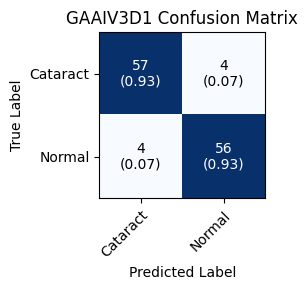

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the saved model
#model = tf.keras.models.load_model('models/final_model.h5')  # Update with the correct path

# Generate predictions for the test data


# Generate the confusion matrix
InceptionV3CM = confusion_matrix(true_labels, InceptionV3Predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(5, 3))
class_names = list(test_generator.class_indices.keys())
#sns.heatmap(InceptionV3CM, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plot_confusion_matrix(conf_mat=InceptionV3CM, figsize=(5, 3), class_names=['Cataract', 'Normal'], show_normed=True)
plt.title('GAAIV3D1 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
#plt.savefig('GAAIV3D1.eps',dpi=250)
plt.show()


In [41]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_model1, tpr_model1, thresholds_model1 = roc_curve(true_labels, MobileNetPredicted_labels)
auc_model1 = roc_auc_score(true_labels, MobileNetPredicted_labels)

# Calculate ROC curve and AUC for Model 2
fpr_model2, tpr_model2, thresholds_model2 = roc_curve(true_labels, InceptionV3Predicted_labels)
auc_model2 = roc_auc_score(true_labels, InceptionV3Predicted_labels)


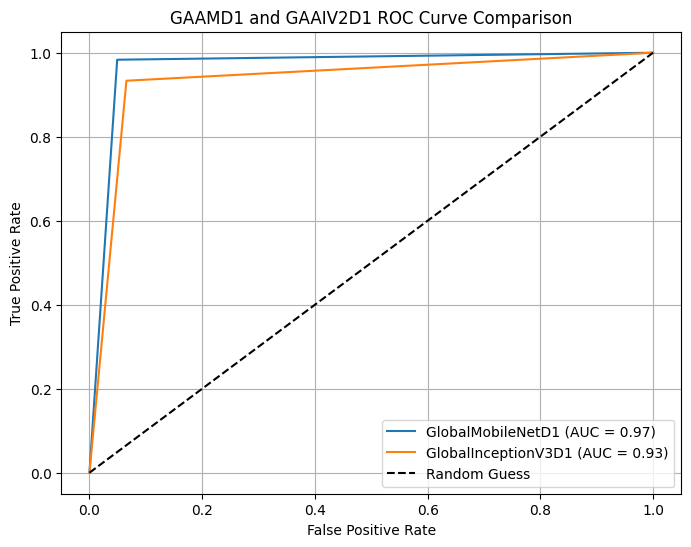

In [42]:
import matplotlib.pyplot as plt

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_model1, tpr_model1, label='GlobalMobileNetD1 (AUC = {:.2f})'.format(auc_model1))
plt.plot(fpr_model2, tpr_model2, label='GlobalInceptionV3D1 (AUC = {:.2f})'.format(auc_model2))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GAAMD1 and GAAIV2D1 ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
#plt.savefig('GAAMvsGAAIRoc.eps',dpi=250)
plt.show()


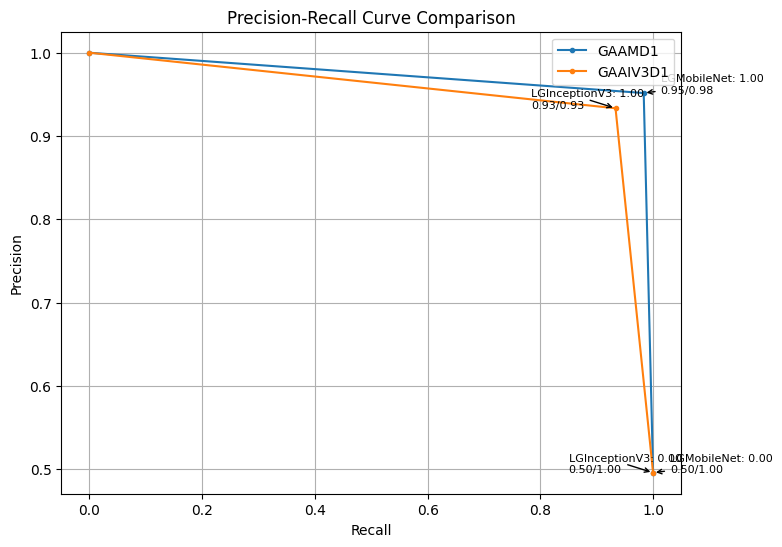

In [43]:
from sklearn.metrics import precision_recall_curve

# Assuming you have predictions and true labels for both models
# Replace 'MobileNetPredicted_labels' and 'InceptionV3Predicted_labels' with the predictions of your models
# Replace 'true_labels' with the true labels of your data

# Calculate precision-recall curve for Model 1
precision_model1, recall_model1, thresholds_model1 = precision_recall_curve(true_labels, MobileNetPredicted_labels)

# Calculate precision-recall curve for Model 2
precision_model2, recall_model2, thresholds_model2 = precision_recall_curve(true_labels, InceptionV3Predicted_labels)

import matplotlib.pyplot as plt

# Plot the precision-recall curves for both models
plt.figure(figsize=(8, 6))
plt.plot(recall_model1, precision_model1, marker='.', label='GAAMD1')
plt.plot(recall_model2, precision_model2, marker='.', label='GAAIV3D1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()

# Annotate points with precision-recall values for Model 1
for p, r, t in zip(precision_model1, recall_model1, thresholds_model1):
    plt.annotate(f'LGMobileNet: {t:.2f}\n{p:.2f}/{r:.2f}', xy=(r, p), xytext=(r + 0.03, p), arrowprops=dict(arrowstyle='->'), fontsize=8)

# Annotate points with precision-recall values for Model 2
for p, r, t in zip(precision_model2, recall_model2, thresholds_model2):
    plt.annotate(f'LGInceptionV3: {t:.2f}\n{p:.2f}/{r:.2f}', xy=(r, p), xytext=(r - 0.15, p), arrowprops=dict(arrowstyle='->'), fontsize=8)

plt.grid(True)
#plt.savefig('GAAMvsGAAID1PR.eps',dpi=250)
plt.show()


In [44]:
MobileNetModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 mobilenet_1.00_224 (Functional  (None, 7, 7, 1024)  3228864     ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 global_average_pooling2d (Glob  (None, 1024)        0           ['mobilenet_1.00_224[0][0]']     
 alAveragePooling2D)                                                                          

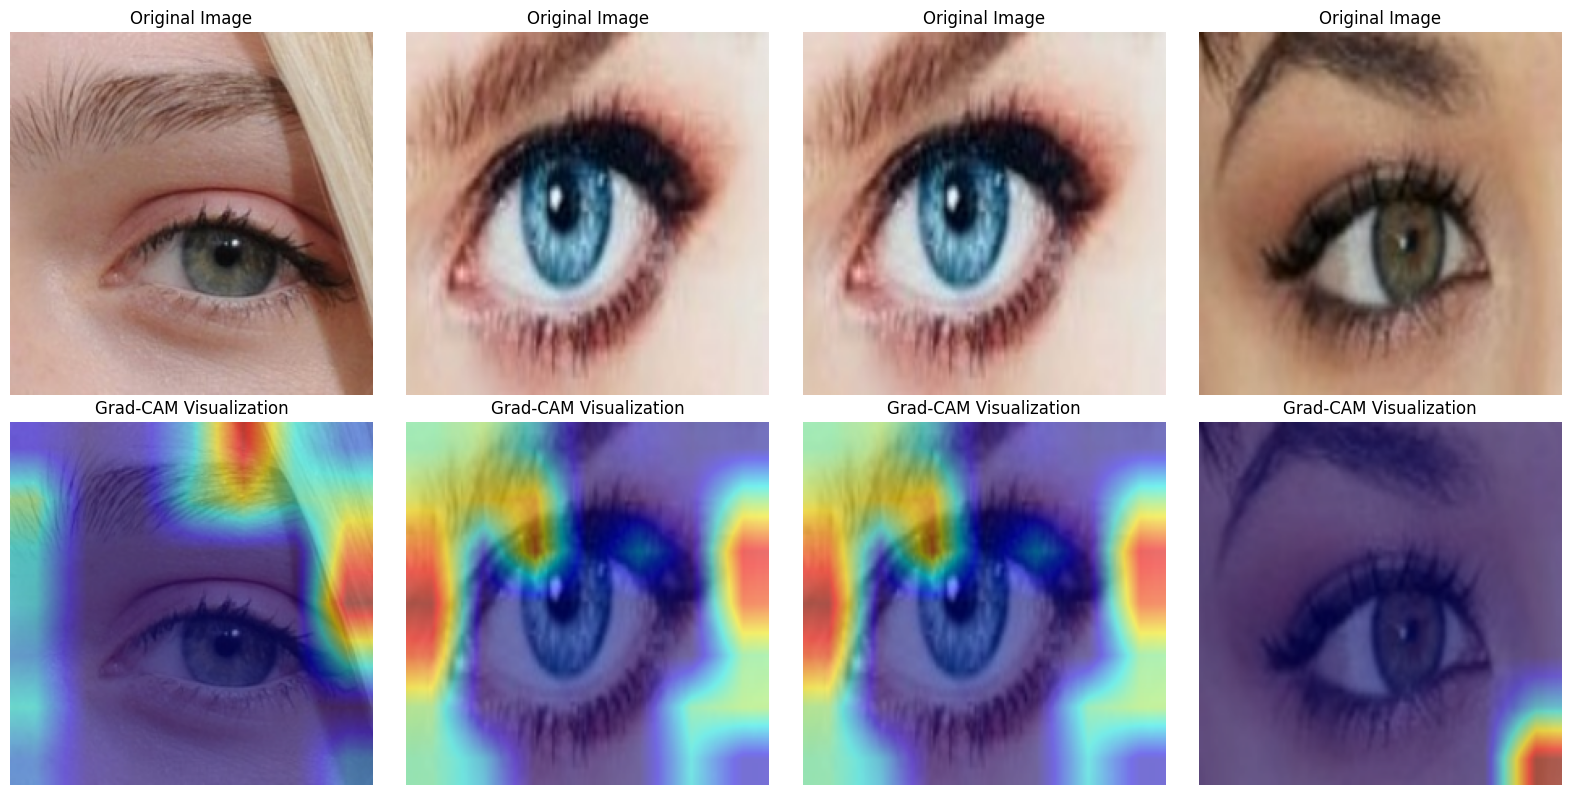

In [45]:
import numpy as np
import cv2
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Step 1: Load and preprocess the image data (Replace 'your_image_path' with the image you want to visualize)
# Step 1: Load and preprocess the image data
test_folder = '/kaggle/input/cataract-image-dataset/processed_images/test'
input_size = (224, 224)  # Input size of the model, adjust according to your model's input size
# Step 2: Pick 4 sample images (2 from 'cataract' class and 2 from 'normal' class)
class_folders = ['cataract', 'normal']
sample_images = []

for class_folder in class_folders:
    class_path = os.path.join(test_folder, class_folder)
    images = os.listdir(class_path)
    sample_images.extend(random.sample(images, 2))

def preprocess_image(image_path, input_size):
    img = load_img(image_path, target_size=input_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)  # Preprocess based on VGG16 requirements
    return img


# Step 3: Define a function to compute the Grad-CAM visualization
def compute_gradcam(model, image):
    # Get the last convolutional layer and the output layer of the model
    last_conv_layer = model.get_layer('multiply')
    output_layer = model.layers[-1]

    # Create a model that maps the input image to the output class predictions and the last convolutional layer
    grad_model = Model(inputs=model.input, outputs=[last_conv_layer.output, output_layer.output])

    # Compute the gradients of the predicted class with respect to the last convolutional layer
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image)
        loss = predictions[:, 0]  # Assuming binary classification, change this if you have different output classes

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map by its corresponding gradient importance
    conv_output = conv_output[0]
    heatmap = tf.reduce_sum(tf.multiply(conv_output, pooled_grads), axis=-1)
    heatmap = np.maximum(heatmap, 0)  # Apply ReLU activation
    heatmap /= np.max(heatmap)  # Normalize the heatmap values between 0 and 1

    return heatmap


# Create a figure with subplots for original images and their Grad-CAM images
num_images = len(sample_images)
fig, axes = plt.subplots(2, num_images, figsize=(4*num_images, 8))

# Generate Grad-CAM for each image and plot the results
for i, image_name in enumerate(sample_images):
    class_folder = 'cataract' if 'cataract' in image_name else 'normal'
    image_path = os.path.join(test_folder, class_folder, image_name)
    image = preprocess_image(image_path, input_size)
    heatmap = compute_gradcam(MobileNetModel, image)
    heatmap = cv2.resize(heatmap, (input_size[1], input_size[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    # Load the original image
    original_image = cv2.imread(image_path)
    original_image = cv2.resize(original_image, (input_size[1], input_size[0]))

    # Overlay the heatmap on the original image
    alpha = 0.5  # Adjust the alpha value for the heatmap overlay
    superimposed_img = cv2.addWeighted(original_image, alpha, heatmap, 1 - alpha, 0)

    # Display the original image and Grad-CAM side by side
    axes[0, i].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axes[0, i].set_title('Original Image')
    axes[0, i].axis('off')

    axes[1, i].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    axes[1, i].set_title('Grad-CAM Visualization')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('LGAAM_D2_GradCamVisualization.eps',dpi=300)
plt.show()

In the Grad-CAM heatmap:

Regions with warm colors (e.g., red, orange, and yellow) indicate high importance or high activation. 
These regions are crucial for the model's prediction, and the model relies heavily on the features extracted 
from these areas to make its decision.

Regions with cool colors (e.g., blue and green) indicate low importance or low activation. 
These regions are less relevant to the model's prediction, and the model does not rely much on 
the features from these areas to make its decision.

In a binary classification scenario like this, where the model predicts between 'cataract' and 'normal' 
classes, the heatmap will show which parts of the image the model considers important for classifying 
the input as 'cataract' (warm regions) and which parts are not as relevant for the 'normal' class (cool regions).

In [46]:
MobileNetModelWA = create_Global_attention_augmented_mobilenet(input_shape + (3,), num_classes,attention=False)

# 4. Compile the model
MobileNetModelWA.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [47]:
InceptionV3ModelWA = create_Global_InceptionV3_model(input_shape + (3,), num_classes,attention=False)

InceptionV3ModelWA.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [48]:
# 5. Train the model
epochs = 100

# Create a directory to save the best model weights during training
os.makedirs('models', exist_ok=True)
model_checkpoint = ModelCheckpoint('models/best_GlobalmobilnetmodelD1.h5', save_best_only=True, save_weights_only=True)

history = MobileNetModelWA.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=[model_checkpoint,cp_callback3]
)


Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 1.3777 - accuracy: 0.7119
Epoch 1: val_loss improved from inf to 0.15665, saving model to ./fpseweights2.h5
12/12 [==============================] - 21s 2s/step - loss: 1.3777 - accuracy: 0.7119 - val_loss: 0.1567 - val_accuracy: 0.9479
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.9197
Epoch 2: val_loss improved from 0.15665 to 0.12051, saving model to ./fpseweights2.h5
12/12 [==============================] - 18s 2s/step - loss: 0.2022 - accuracy: 0.9197 - val_loss: 0.1205 - val_accuracy: 0.9688
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9474
Epoch 3: val_loss did not improve from 0.12051
12/12 [==============================] - 17s 1s/step - loss: 0.1351 - accuracy: 0.9474 - val_loss: 0.1717 - val_accuracy: 0.9271
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 0.1216 - accuracy: 0.9474
Epoch 4: val_loss 

In [49]:
# 6. Evaluate the model
MobileNetEvaluationWA = MobileNetModelWA.evaluate(validation_generator)
print("Validation Accuracy: {:.2f}%".format(MobileNetEvaluationWA[1] * 100))

4/4 [==============================] - 2s 509ms/step - loss: 0.1209 - accuracy: 0.9796
Validation Accuracy: 97.96%


In [50]:
# Generate predictions for the test set
MobileNetPredictionsWA = MobileNetModelWA.predict_generator(test_generator)
MobileNetPredicted_labelsWA = np.argmax(MobileNetPredictionsWA, axis=1)
MobileNetReportWA = classification_report(true_labels, MobileNetPredicted_labelsWA, target_names=class_names)
print(MobileNetReportWA)


/tmp/ipykernel_29/52924266.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  MobileNetPredictionsWA = MobileNetModelWA.predict_generator(test_generator)


              precision    recall  f1-score   support

    cataract       0.95      0.95      0.95        61
      normal       0.95      0.95      0.95        60

    accuracy                           0.95       121
   macro avg       0.95      0.95      0.95       121
weighted avg       0.95      0.95      0.95       121



In [51]:
# 6. Evaluate the model
MobileNetEvaluationWA = MobileNetModelWA.evaluate(validation_generator)
print("Validation Accuracy: {:.2f}%".format(MobileNetEvaluationWA[1] * 100))

4/4 [==============================] - 2s 517ms/step - loss: 0.0755 - accuracy: 0.9592
Validation Accuracy: 95.92%


In [52]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
NUM_CLASSES = 2  # Binary classification
IMG_SIZE = 224  # Size of the input images for DenseNet201

# Load pre-trained DenseNet201 model without the top classification layers
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(1024, activation='relu')(x)  # Dense layer with ReLU activation
predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)  # Output layer with sigmoid activation for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])



74836368/74836368 [==============================] - 3s 0us/step


In [53]:
cp_callback4 = tf.keras.callbacks.ModelCheckpoint('./fpseweights4.h5', save_weights_only=True, verbose=1, save_best_only=True)

In [ ]:
os.makedirs('models', exist_ok=True)
model_checkpoint = ModelCheckpoint('models/best_DenseNet201_model.h5', save_best_only=True, save_weights_only=True)

# Assuming you have 'train_generator' and 'validation_generator' defined with your ImageDataGenerator instances

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=[model_checkpoint,cp_callback4]
)

Epoch 1/100
 2/12 [====>.........................] - ETA: 0s - loss: 1.2652 - accuracy: 0.5312  